In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nltk

nltk.download("gutenberg")

[nltk_data] Downloading package gutenberg to /home/vscode/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [3]:
import re
from pathlib import Path
from typing import Final, TypeAlias

import numpy as np
import pandas as pd
import shap
from IPython.display import display
from matplotlib import pyplot as plt
from nltk.corpus import gutenberg
from pandas import DataFrame
from shap import Explainer

from authorship_tool.types_ import AuthorColl4dStr, Doc3dStr, Para2dStr, Tag
from authorship_tool.util import dim_reshaper
from authorship_tool.util.feature.dataset_generator import (
    ParagraphFeatureDatasetGenerator,
)
from authorship_tool.util.feature.pos import PosFeature
from authorship_tool.util.ml import cv_trainer
from authorship_tool.util.ml import trainer as trainer
from authorship_tool.util.ml.model import (
    CrossValidationResult,
    CvGlobalExplanationData,
    LGBMSource,
    Score,
    TrainingResult,
    dump,
    pred_crosstab,
)
from authorship_tool.util.path_util import GutenbergKFoldPaths, GutenbergPaths

Project root: /workspaces/shap-authorship-analysis-demo
Path: data/john_blake_2023/wordLists/adjectives/participle/adjectivesPastParticiple.csv
Path: data/john_blake_2023/wordLists/adjectives/participle/adjectivesPresentParticiple.csv
Path: data/john_blake_2023/wordLists/adjectives/limit/limit_adjectives.csv
Path: data/john_blake_2023/wordLists/adjectives/extraposition/adjectives_extraposition.csv
Path: data/liyanage_vijini_2022/Dataset/FullyGenerated
Path: data/liyanage_vijini_2022/Dataset/Hybrid_AbstractDataset
Path: data/uoa-thesis-2014-2017
Path: out/text_data
Path: out/processed_text
Path: out/dataset
Path: out/lgbm/model
Path: out/shap/figure


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
np.seterr(divide="call")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


In [5]:
AUTHOR_A: Final[str] = "chesterton"
AUTHOR_B: Final[str] = "bryant"


In [6]:
for idx, file_id in enumerate(iterable=gutenberg.fileids()):
    print(f"#{idx+1}\t{file_id}")


#1	austen-emma.txt
#2	austen-persuasion.txt
#3	austen-sense.txt
#4	bible-kjv.txt
#5	blake-poems.txt
#6	bryant-stories.txt
#7	burgess-busterbrown.txt
#8	carroll-alice.txt
#9	chesterton-ball.txt
#10	chesterton-brown.txt
#11	chesterton-thursday.txt
#12	edgeworth-parents.txt
#13	melville-moby_dick.txt
#14	milton-paradise.txt
#15	shakespeare-caesar.txt
#16	shakespeare-hamlet.txt
#17	shakespeare-macbeth.txt
#18	whitman-leaves.txt


In [7]:
Author: TypeAlias = str
NumOfParas: TypeAlias = int

authors: set[Author] = {
    match.group(1)
    for file_id in gutenberg.fileids()
    if (match := re.search(r"^(.+?)-", file_id)) is not None
}

para_size_by_author: dict[Author, NumOfParas] = {}

for index, author in enumerate(authors):
    books_of_author: AuthorColl4dStr = [
        gutenberg.paras(fileids=file_id)
        for file_id in gutenberg.fileids()
        if author in file_id
    ]

    para_num: NumOfParas = len([para for paras in books_of_author for para in paras])
    para_size_by_author[author] = para_num

sorted_para_size_by_author: dict[Author, NumOfParas] = dict(
    sorted(para_size_by_author.items(), key=lambda item: item[1], reverse=True)
)

for idx, item in enumerate(sorted_para_size_by_author.items()):
    print(f"{idx + 1}:\t{item[0]} - {item[1]} paragraphs")


1:	bible - 24608 paragraphs
2:	austen - 5265 paragraphs
3:	chesterton - 4055 paragraphs
4:	edgeworth - 3726 paragraphs
5:	melville - 2793 paragraphs
6:	whitman - 2478 paragraphs
7:	shakespeare - 2372 paragraphs
8:	bryant - 1194 paragraphs
9:	carroll - 817 paragraphs
10:	blake - 284 paragraphs
11:	burgess - 266 paragraphs
12:	milton - 29 paragraphs


In [8]:
books_a: AuthorColl4dStr = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_A in file_id
]

paras_a: Doc3dStr = [para for paras in books_a for para in paras]

for para in paras_a[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nAuthor: {AUTHOR_A}, {len(paras_a)} paragraphs\n")


[ The Ball and The Cross by G . K . Chesterton 1909 ]
I . A DISCUSSION SOMEWHAT IN THE AIR
The flying ship of Professor Lucifer sang through the skies like a silver arrow ; the bleak white steel of it , gleaming in the bleak blue emptiness of the evening . That it was far above the earth was no expression for it ; to the two men in it , it seemed to be far above the stars . The professor had himself invented the flying machine , and had also invented nearly everything in it . Every sort of tool or apparatus had , in consequence , to the full , that fantastic and distorted look which belongs to the miracles of science . For the world of science and evolution is far more nameless and elusive and like a dream than the world of poetry and religion ; since in the latter images and ideas remain themselves eternally , while it is the whole idea of evolution that identities melt into each other as they do in a nightmare .
All the tools of Professor Lucifer were the ancient human tools gone mad

In [9]:
books_b: AuthorColl4dStr = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_B in file_id
]

paras_b: Doc3dStr = [para for paras in books_b for para in paras]

for para in paras_b[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nAuthor: {AUTHOR_B}, {len(paras_b)} paragraphs\n")


[ Stories to Tell to Children by Sara Cone Bryant 1918 ]
TWO LITTLE RIDDLES IN RHYME
There ' s a garden that I ken , Full of little gentlemen ; Little caps of blue they wear , And green ribbons , very fair . ( Flax .)
From house to house he goes , A messenger small and slight , And whether it rains or snows , He sleeps outside in the night . ( The path .)
THE LITTLE YELLOW TULIP
Once there was a little yellow Tulip , and she lived down in a little dark house under the ground . One day she was sitting there , all by herself , and it was very still . Suddenly , she heard a little _tap , tap , tap_ , at the door .
" Who is that ?" she said .
" It ' s the Rain , and I want to come in ," said a soft , sad , little voice .
" No , you can ' t come in ," the little Tulip said .
By and by she heard another little _tap , tap , tap_ on the window - pane .
" Who is there ?" she said .
The same soft little voice answered , " It ' s the Rain , and I want to come in !"
" No , you can ' t come in ," s

In [10]:
print(f"total: {len(paras_a + paras_b)} paragraphs (samples)")


total: 5249 paragraphs (samples)


In [11]:
all_paras: list[Para2dStr] = paras_a + paras_b

all_pos: list[Tag] = PosFeature(all_paras).tag_subcategories().all_pos

print(all_pos)


['$', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'JJ_exp', 'JJ_lim', 'JJ_pp', 'JJ_presp', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [12]:
dataset_generator = ParagraphFeatureDatasetGenerator(tags=all_pos)


In [13]:
para_ans_pairs: list[tuple[Para2dStr, bool]] = [(para, True) for para in paras_a] + [
    (para, False) for para in paras_b
]


In [14]:
dataset_list: list[pd.Series] = [
    dataset_generator.generate_from_paragraph(para, answer)
    for para, answer in para_ans_pairs
]


In [15]:
datasets: DataFrame = pd.concat(dataset_list, axis=1).reset_index(drop=True).T


In [16]:
datasets.columns = (*dataset_generator.columns, "answer")
for col, dtype in zip(
    datasets.columns,
    dataset_generator.dtypes + [bool],
    strict=True,
):
    datasets[col] = datasets[col].astype(dtype)


In [17]:
df = datasets.iloc[:, :-1]
display(df.head(10))


,v1 sentences per paragraph,v2 words per paragraph,v3 close parenthesis present,v4 dash present,v5 semi-colon or colon present,v6 question mark present,v7 apostrophe present,v8 standard deviation of sentence length,v9 length difference for consecutive sentences,v10 sentence with < 11 words,v11 sentence with > 34 words,v12 contains 'although',v13 contains 'however',v14 contains 'but',v15 contains 'because',v16 contains 'this',v17 contains 'others' or 'researchers',v18 contains numbers,v19 contains 2 times more capitals than period,v20 contains 'et',word variation,average word length,non alphabetic characters frequency,uncommon word frequency,non-alphabetic characters frequency,numeric value frequency,$,'',(,),",",.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,JJ_exp,JJ_lim,JJ_pp,JJ_presp,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``
0,1,14,False,False,False,False,False,0.000000,0.000000,False,False,False,False,False,False,False,False,True,True,False,0.857143,2.857143,0.571429,0.857143,0.571429,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.142857,0.000000,0.071429,0.071429,0.142857,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.071429,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,2,8,False,False,False,False,False,2.000000,4.000000,True,False,False,False,False,False,False,False,False,True,False,1.000000,3.625000,0.125000,1.000000,0.125000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.625000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,5,164,False,False,True,False,False,12.983066,13.250000,False,True,False,False,False,False,False,False,False,False,False,0.573171,4.103659,0.091463,0.530488,0.091463,0.0,0.0,0.0,0.000000,0.000000,0.042683,0.030488,0.018293,0.048780,0.006098,0.128049,0.000000,0.006098,0.176829,0.067073,0.006098,0.000000,0.0,0.006098,0.0,0.000000,0.000000,0.164634,0.018293,0.000000,0.036585,0.000000,0.000000,0.060976,0.000000,0.036585,0.000000,0.000000,0.000000,0.0,0.024390,0.0,0.006098,0.042683,0.018293,0.012195,0.012195,0.024390,0.006098,0.0,0.000000,0.000000,0.0
3,6,149,False,True,True,False,False,4.669642,6.200000,False,False,False,False,True,False,True,False,False,False,False,0.637584,4.389262,0.120805,0.590604,0.120805,0.0,0.0,0.0,0.000000,0.000000,0.067114,0.040268,0.013423,0.013423,0.013423,0.107383,0.000000,0.000000,0.114094,0.040268,0.000000,0.006711,0.0,0.013423,0.0,0.000000,0.006711,0.134228,0.013423,0.000000,0.046980,0.013423,0.000000,0.046980,0.013423,0.060403,0.000000,0.000000,0.000000,0.0,0.020134,0.0,0.020134,0.087248,0.006711,0.067114,0.006711,0.000000,0.026846,0.0,0.000000,0.000000,0.0
4,8,294,True,False,True,False,False,18.699933,22.857143,False,True,False,True,True,False,False,False,True,False,False,0.544218,4.125850,0.136054,0.574830,0.136054,0.0,0.0,0.0,0.003401,0.003401,0.085034,0.027211,0.003401,0.037415,0.010204,0.088435,0.003401,0.000000,0.115646,0.105442,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.003401,0.122449,0.010204,0.003401,0.034014,0.003401,0.000000,0.064626,0.020408,0.091837,0.000000,0.003401,0.003401,0.0,0.017007,0.0,0.023810,0.068027,0.006803,0.030612,0.003401,0.000000,0.003401,0.0,0.003401,0.000000,0.0
5,5,91,False,True,False,False,False,13.511477,15.250000,True,True,False,False,False,False,True,False,False,False,False,0.758242,4.637363,0.175824,0.593407,0.175824,0.0,0.0,0.0,0.000000,0.000000,0.032967,0.043956,0.000000,0.021978,0.000000,0.076923,0.000000,0.000000,0.131868,0.054945,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.010989,0.142857,0.054945,0.000

In [18]:
nd_category = np.array(datasets.iloc[:, -1], dtype=bool)
display(nd_category[:5])


array([ True,  True,  True,  True,  True])

In [19]:
print(df.shape)


(5249, 73)


In [20]:
print(df.dtypes)


v1 sentences per paragraph                          int64
v2 words per paragraph                              int64
v3 close parenthesis present                         bool
v4 dash present                                      bool
v5 semi-colon or colon present                       bool
v6 question mark present                             bool
v7 apostrophe present                                bool
v8 standard deviation of sentence length          float64
v9 length difference for consecutive sentences    float64
v10 sentence with < 11 words                         bool
v11 sentence with > 34 words                         bool
v12 contains 'although'                              bool
v13 contains 'however'                               bool
v14 contains 'but'                                   bool
v15 contains 'because'                               bool
v16 contains 'this'                                  bool
v17 contains 'others' or 'researchers'               bool
v18 contains n

In [21]:
print(df.isna().sum())


v1 sentences per paragraph                        0
v2 words per paragraph                            0
v3 close parenthesis present                      0
v4 dash present                                   0
v5 semi-colon or colon present                    0
v6 question mark present                          0
v7 apostrophe present                             0
v8 standard deviation of sentence length          0
v9 length difference for consecutive sentences    0
v10 sentence with < 11 words                      0
v11 sentence with > 34 words                      0
v12 contains 'although'                           0
v13 contains 'however'                            0
v14 contains 'but'                                0
v15 contains 'because'                            0
v16 contains 'this'                               0
v17 contains 'others' or 'researchers'            0
v18 contains numbers                              0
v19 contains 2 times more capitals than period    0
v20 contains

In [22]:
source: LGBMSource = LGBMSource(feature_data_frame=df, nd_category=nd_category)
result: TrainingResult = trainer.train_once(source)


[LightGBM] [Info] Number of positive: 3239, number of negative: 960
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9893
[LightGBM] [Info] Number of data points in the train set: 4199, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.771374 -> initscore=1.216087
[LightGBM] [Info] Start training from score 1.216087


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [23]:
score: Score | None = result.score


In [24]:
if score is not None:
    print(f"auc-roc score: {score.auc_roc_score}")
    print(f"f1 score: {score.f1_score}")
    print(f"accuracy score: {score.accuracy_score}")


auc-roc score: 0.8854245223730517
f1 score: 0.9166173861620343
accuracy score: 0.8657142857142858


In [25]:
display(pred_crosstab(result.splitted_dataset.test_ans, result.prediction.pred_ans))


predicted,False,True
actual,,
False,134,100
True,41,775


In [26]:
dump(result, GutenbergPaths)


In [27]:
test_data: DataFrame = result.splitted_dataset.test_data
explainer: Explainer = result.shap_data.explainer
shap_expected_val: np.float64 = result.shap_data.shap_expected_val
shap_vals = result.shap_data.shap_vals

FIRST_DATA_INDEX: Final[int] = 0


In [28]:
shap.initjs()


In [29]:
SHAP_GUTENBERG_FIGURE_DIR: Path = GutenbergPaths.shap_figure_dir


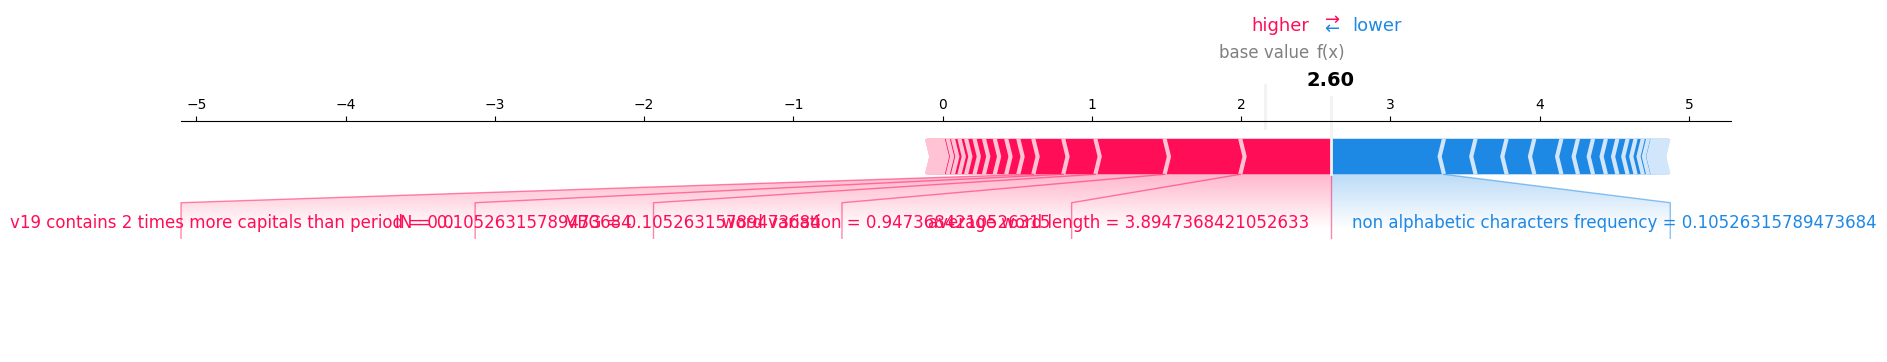

<Figure size 640x480 with 0 Axes>

In [30]:
shap.force_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
)
shap.force_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
    matplotlib=True,
    show=False,
)
plt.savefig(
    SHAP_GUTENBERG_FIGURE_DIR.joinpath("shap_force_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()


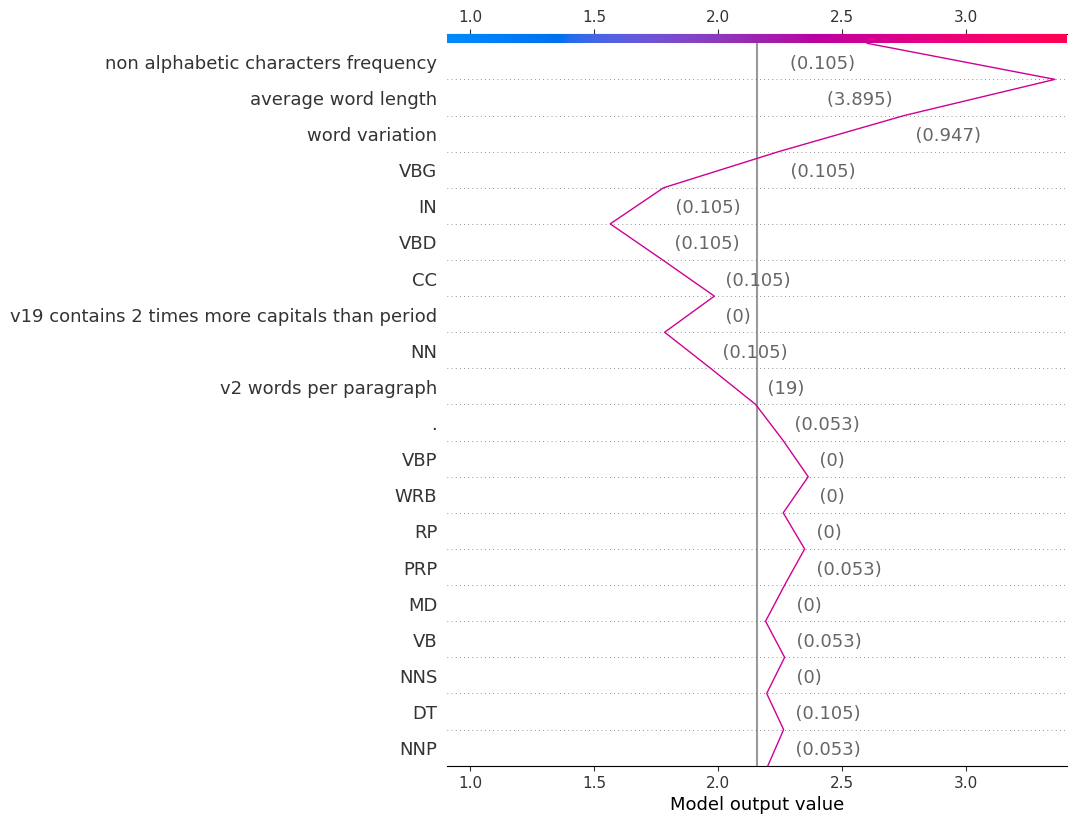

<Figure size 640x480 with 0 Axes>

In [31]:
shap.decision_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
    show=False,
)
plt.savefig(
    SHAP_GUTENBERG_FIGURE_DIR.joinpath("shap_decision_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()


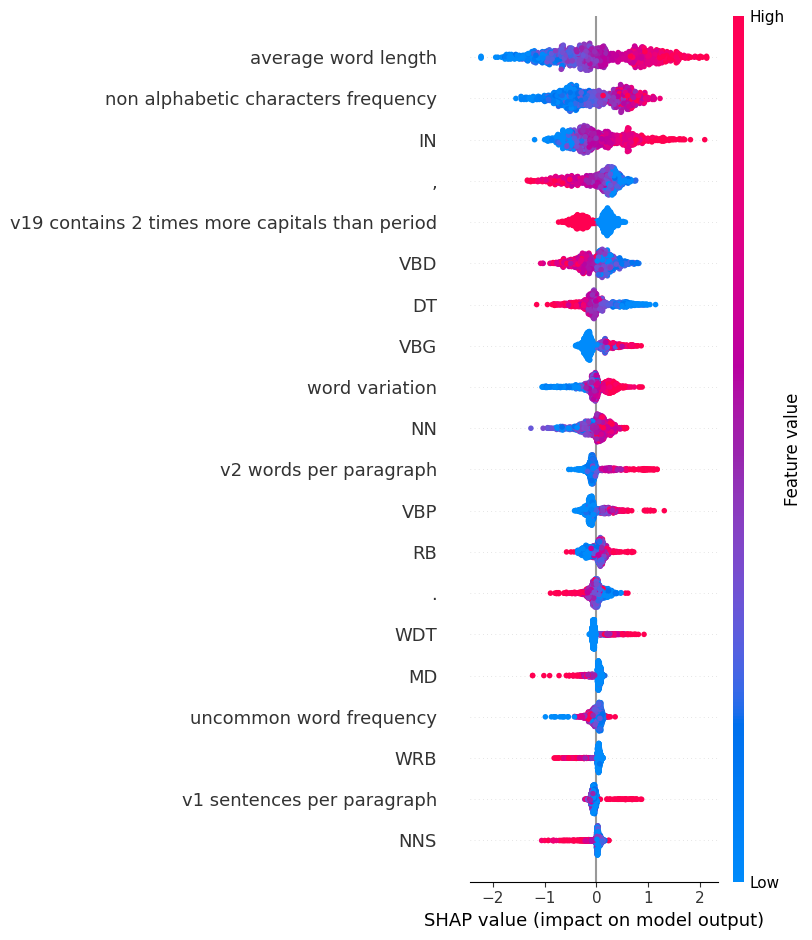

<Figure size 640x480 with 0 Axes>

In [32]:
shap.summary_plot(
    shap_vals,
    test_data,
    show=False,
)
plt.savefig(
    SHAP_GUTENBERG_FIGURE_DIR.joinpath("shap_summary_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()


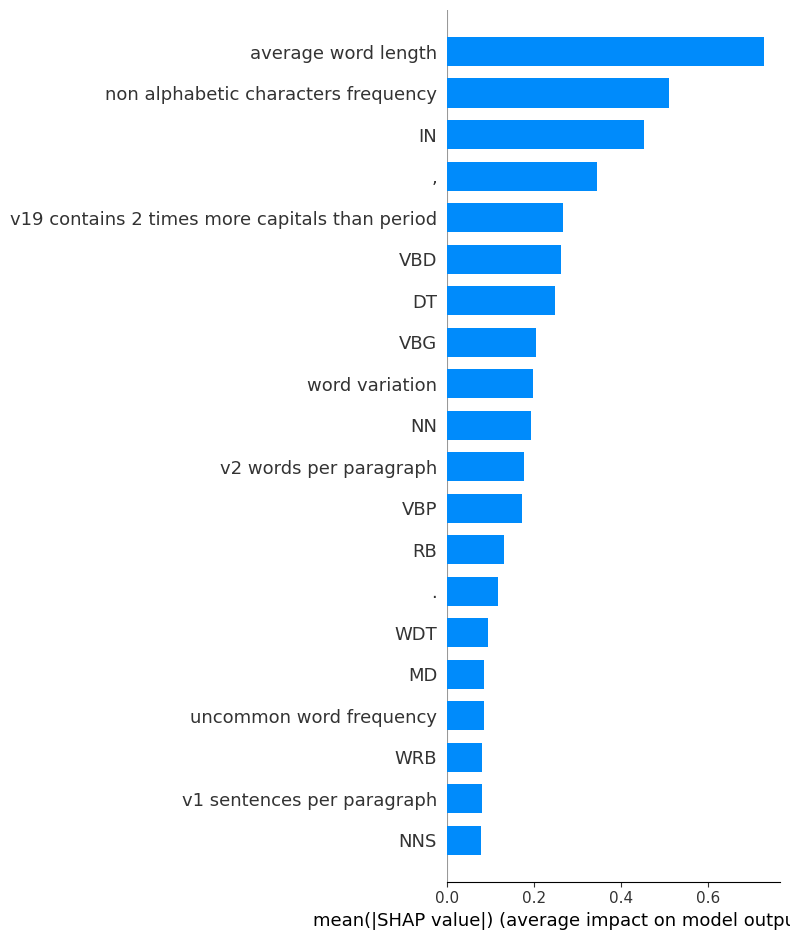

<Figure size 640x480 with 0 Axes>

In [33]:
shap.summary_plot(
    shap_vals,
    test_data,
    plot_type="bar",
    show=False,
)
plt.savefig(
    SHAP_GUTENBERG_FIGURE_DIR.joinpath("shap_summary_plot_bar.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()


In [34]:

results_for_each_iters: list[TrainingResult] = cv_trainer.train_kfold(source, 100)


[LightGBM] [Info] Number of positive: 4015, number of negative: 1181
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10140
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772710 -> initscore=1.223676
[LightGBM] [Info] Start training from score 1.223676


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4010, number of negative: 1186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10146
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.771747 -> initscore=1.218205
[LightGBM] [Info] Start training from score 1.218205


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4015, number of negative: 1181
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10147
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772710 -> initscore=1.223676
[LightGBM] [Info] Start training from score 1.223676


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4014, number of negative: 1182
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10159
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772517 -> initscore=1.222580
[LightGBM] [Info] Start training from score 1.222580


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4017, number of negative: 1179
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10143
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.773095 -> initscore=1.225869
[LightGBM] [Info] Start training from score 1.225869


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4013, number of negative: 1183
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10159
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772325 -> initscore=1.221486
[LightGBM] [Info] Start training from score 1.221486


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4014, number of negative: 1182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10161
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772517 -> initscore=1.222580
[LightGBM] [Info] Start training from score 1.222580


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4014, number of negative: 1182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10160
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772517 -> initscore=1.222580
[LightGBM] [Info] Start training from score 1.222580


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4013, number of negative: 1183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10168
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772325 -> initscore=1.221486
[LightGBM] [Info] Start training from score 1.221486


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4013, number of negative: 1183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10163
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772325 -> initscore=1.221486
[LightGBM] [Info] Start training from score 1.221486


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4013, number of negative: 1183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10161
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772325 -> initscore=1.221486
[LightGBM] [Info] Start training from score 1.221486


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4015, number of negative: 1181
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10153
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772710 -> initscore=1.223676
[LightGBM] [Info] Start training from score 1.223676


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4018, number of negative: 1178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10165
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.773287 -> initscore=1.226966
[LightGBM] [Info] Start training from score 1.226966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4013, number of negative: 1183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10159
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772325 -> initscore=1.221486
[LightGBM] [Info] Start training from score 1.221486


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4012, number of negative: 1184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10156
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772132 -> initscore=1.220391
[LightGBM] [Info] Start training from score 1.220391


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4015, number of negative: 1181
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10142
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772710 -> initscore=1.223676
[LightGBM] [Info] Start training from score 1.223676


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4010, number of negative: 1186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10152
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.771747 -> initscore=1.218205
[LightGBM] [Info] Start training from score 1.218205


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4014, number of negative: 1182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10164
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772517 -> initscore=1.222580
[LightGBM] [Info] Start training from score 1.222580


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4014, number of negative: 1182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10181
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772517 -> initscore=1.222580
[LightGBM] [Info] Start training from score 1.222580


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4016, number of negative: 1180
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10150
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772902 -> initscore=1.224772
[LightGBM] [Info] Start training from score 1.224772


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4012, number of negative: 1184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772132 -> initscore=1.220391
[LightGBM] [Info] Start training from score 1.220391


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4020, number of negative: 1176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10153
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.773672 -> initscore=1.229163
[LightGBM] [Info] Start training from score 1.229163


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4017, number of negative: 1179
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10174
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.773095 -> initscore=1.225869
[LightGBM] [Info] Start training from score 1.225869


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4024, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10147
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.774442 -> initscore=1.233565
[LightGBM] [Info] Start training from score 1.233565


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4019, number of negative: 1177
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10152
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.773480 -> initscore=1.228064
[LightGBM] [Info] Start training from score 1.228064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4019, number of negative: 1177
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10146
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.773480 -> initscore=1.228064
[LightGBM] [Info] Start training from score 1.228064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4011, number of negative: 1185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10144
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.771940 -> initscore=1.219298
[LightGBM] [Info] Start training from score 1.219298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4013, number of negative: 1183
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10159
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772325 -> initscore=1.221486
[LightGBM] [Info] Start training from score 1.221486


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4018, number of negative: 1178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10174
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.773287 -> initscore=1.226966
[LightGBM] [Info] Start training from score 1.226966


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4019, number of negative: 1177
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10135
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.773480 -> initscore=1.228064
[LightGBM] [Info] Start training from score 1.228064


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4014, number of negative: 1182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10168
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772517 -> initscore=1.222580
[LightGBM] [Info] Start training from score 1.222580


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4013, number of negative: 1183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10163
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772325 -> initscore=1.221486
[LightGBM] [Info] Start training from score 1.221486


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4010, number of negative: 1186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10139
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.771747 -> initscore=1.218205
[LightGBM] [Info] Start training from score 1.218205


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4016, number of negative: 1180
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10152
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772902 -> initscore=1.224772
[LightGBM] [Info] Start training from score 1.224772


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4015, number of negative: 1181
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10151
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772710 -> initscore=1.223676
[LightGBM] [Info] Start training from score 1.223676


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4017, number of negative: 1179
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10148
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.773095 -> initscore=1.225869
[LightGBM] [Info] Start training from score 1.225869


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4014, number of negative: 1182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10156
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772517 -> initscore=1.222580
[LightGBM] [Info] Start training from score 1.222580


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4011, number of negative: 1185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10178
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.771940 -> initscore=1.219298
[LightGBM] [Info] Start training from score 1.219298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4012, number of negative: 1184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10162
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772132 -> initscore=1.220391
[LightGBM] [Info] Start training from score 1.220391


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4009, number of negative: 1187
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10131
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.771555 -> initscore=1.217113
[LightGBM] [Info] Start training from score 1.217113


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4017, number of negative: 1179
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10155
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.773095 -> initscore=1.225869
[LightGBM] [Info] Start training from score 1.225869


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4011, number of negative: 1185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10182
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.771940 -> initscore=1.219298
[LightGBM] [Info] Start training from score 1.219298


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4012, number of negative: 1184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10176
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772132 -> initscore=1.220391
[LightGBM] [Info] Start training from score 1.220391


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4016, number of negative: 1180
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10146
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772902 -> initscore=1.224772
[LightGBM] [Info] Start training from score 1.224772


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4010, number of negative: 1186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10144
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.771747 -> initscore=1.218205
[LightGBM] [Info] Start training from score 1.218205


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4012, number of negative: 1184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10161
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772132 -> initscore=1.220391
[LightGBM] [Info] Start training from score 1.220391


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4013, number of negative: 1183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10140
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772325 -> initscore=1.221486
[LightGBM] [Info] Start training from score 1.221486


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4015, number of negative: 1181
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10178
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772710 -> initscore=1.223676
[LightGBM] [Info] Start training from score 1.223676


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4014, number of negative: 1182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10152
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772517 -> initscore=1.222580
[LightGBM] [Info] Start training from score 1.222580


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4016, number of negative: 1181
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10145
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772754 -> initscore=1.223925
[LightGBM] [Info] Start training from score 1.223925


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4015, number of negative: 1182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10150
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772561 -> initscore=1.222829
[LightGBM] [Info] Start training from score 1.222829


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4014, number of negative: 1183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10144
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772369 -> initscore=1.221735
[LightGBM] [Info] Start training from score 1.221735


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4014, number of negative: 1183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10150
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772369 -> initscore=1.221735
[LightGBM] [Info] Start training from score 1.221735


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4016, number of negative: 1181
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10146
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772754 -> initscore=1.223925
[LightGBM] [Info] Start training from score 1.223925


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4014, number of negative: 1183
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10155
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772369 -> initscore=1.221735
[LightGBM] [Info] Start training from score 1.221735


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4015, number of negative: 1182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10156
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772561 -> initscore=1.222829
[LightGBM] [Info] Start training from score 1.222829


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4016, number of negative: 1181
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10150
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772754 -> initscore=1.223925
[LightGBM] [Info] Start training from score 1.223925


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4013, number of negative: 1184
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10150
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772176 -> initscore=1.220641
[LightGBM] [Info] Start training from score 1.220641


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4012, number of negative: 1185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10153
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.771984 -> initscore=1.219547
[LightGBM] [Info] Start training from score 1.219547


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4013, number of negative: 1184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772176 -> initscore=1.220641
[LightGBM] [Info] Start training from score 1.220641


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4019, number of negative: 1178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10144
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.773331 -> initscore=1.227215
[LightGBM] [Info] Start training from score 1.227215


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4011, number of negative: 1186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10175
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.771791 -> initscore=1.218454
[LightGBM] [Info] Start training from score 1.218454


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4012, number of negative: 1185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10174
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.771984 -> initscore=1.219547
[LightGBM] [Info] Start training from score 1.219547


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4016, number of negative: 1181
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10165
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772754 -> initscore=1.223925
[LightGBM] [Info] Start training from score 1.223925


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4012, number of negative: 1185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10143
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.771984 -> initscore=1.219547
[LightGBM] [Info] Start training from score 1.219547


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4012, number of negative: 1185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10163
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.771984 -> initscore=1.219547
[LightGBM] [Info] Start training from score 1.219547


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4015, number of negative: 1182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10143
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772561 -> initscore=1.222829
[LightGBM] [Info] Start training from score 1.222829


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4015, number of negative: 1182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10162
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772561 -> initscore=1.222829
[LightGBM] [Info] Start training from score 1.222829


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4017, number of negative: 1180
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10154
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772946 -> initscore=1.225021
[LightGBM] [Info] Start training from score 1.225021


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4013, number of negative: 1184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10146
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772176 -> initscore=1.220641
[LightGBM] [Info] Start training from score 1.220641


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4024, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10165
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.774293 -> initscore=1.232712
[LightGBM] [Info] Start training from score 1.232712


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4013, number of negative: 1184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10144
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772176 -> initscore=1.220641
[LightGBM] [Info] Start training from score 1.220641


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4012, number of negative: 1185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10161
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.771984 -> initscore=1.219547
[LightGBM] [Info] Start training from score 1.219547


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4014, number of negative: 1183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10175
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772369 -> initscore=1.221735
[LightGBM] [Info] Start training from score 1.221735


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4016, number of negative: 1181
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10137
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772754 -> initscore=1.223925
[LightGBM] [Info] Start training from score 1.223925


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4015, number of negative: 1182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10151
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772561 -> initscore=1.222829
[LightGBM] [Info] Start training from score 1.222829


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4017, number of negative: 1180
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10154
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772946 -> initscore=1.225021
[LightGBM] [Info] Start training from score 1.225021


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4015, number of negative: 1182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10161
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772561 -> initscore=1.222829
[LightGBM] [Info] Start training from score 1.222829


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4015, number of negative: 1182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10150
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772561 -> initscore=1.222829
[LightGBM] [Info] Start training from score 1.222829


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4016, number of negative: 1181
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10182
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772754 -> initscore=1.223925
[LightGBM] [Info] Start training from score 1.223925


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4013, number of negative: 1184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10133
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772176 -> initscore=1.220641
[LightGBM] [Info] Start training from score 1.220641


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4017, number of negative: 1180
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10170
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772946 -> initscore=1.225021
[LightGBM] [Info] Start training from score 1.225021


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4011, number of negative: 1186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10141
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.771791 -> initscore=1.218454
[LightGBM] [Info] Start training from score 1.218454


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4014, number of negative: 1183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10166
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772369 -> initscore=1.221735
[LightGBM] [Info] Start training from score 1.221735


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4014, number of negative: 1183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10159
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772369 -> initscore=1.221735
[LightGBM] [Info] Start training from score 1.221735


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4021, number of negative: 1176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.773716 -> initscore=1.229412
[LightGBM] [Info] Start training from score 1.229412


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4014, number of negative: 1183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10143
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772369 -> initscore=1.221735
[LightGBM] [Info] Start training from score 1.221735


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4016, number of negative: 1181
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10155
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772754 -> initscore=1.223925
[LightGBM] [Info] Start training from score 1.223925


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4015, number of negative: 1182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10161
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772561 -> initscore=1.222829
[LightGBM] [Info] Start training from score 1.222829


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4017, number of negative: 1180
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10181
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772946 -> initscore=1.225021
[LightGBM] [Info] Start training from score 1.225021


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4013, number of negative: 1184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10155
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772176 -> initscore=1.220641
[LightGBM] [Info] Start training from score 1.220641


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4011, number of negative: 1186
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10172
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.771791 -> initscore=1.218454
[LightGBM] [Info] Start training from score 1.218454


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4016, number of negative: 1181
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10156
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772754 -> initscore=1.223925
[LightGBM] [Info] Start training from score 1.223925


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4012, number of negative: 1185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10145
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.771984 -> initscore=1.219547
[LightGBM] [Info] Start training from score 1.219547


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4013, number of negative: 1184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10156
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772176 -> initscore=1.220641
[LightGBM] [Info] Start training from score 1.220641


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4015, number of negative: 1182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10155
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772561 -> initscore=1.222829
[LightGBM] [Info] Start training from score 1.222829


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4015, number of negative: 1182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10160
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772561 -> initscore=1.222829
[LightGBM] [Info] Start training from score 1.222829


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4011, number of negative: 1186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10179
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.771791 -> initscore=1.218454
[LightGBM] [Info] Start training from score 1.218454


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4017, number of negative: 1180
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10146
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772946 -> initscore=1.225021
[LightGBM] [Info] Start training from score 1.225021


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4012, number of negative: 1185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10139
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.771984 -> initscore=1.219547
[LightGBM] [Info] Start training from score 1.219547


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [35]:

cv_result: CrossValidationResult = cv_trainer.convert_results_to_cv_result(
    results_for_each_iters
)


In [36]:

cv_global_exp_data: CvGlobalExplanationData = (
    cv_trainer.convert_cv_result_to_global_exp_data(cv_result)
)


In [37]:

cv_score: Score = cv_trainer.calc_score_for_cv(cv_global_exp_data)


In [38]:
if cv_score is not None:
    print(f"auc-roc score:\t{cv_score.auc_roc_score}")
    print(f"f1 score:\t{cv_score.f1_score}")
    print(f"accuracy score:\t{cv_score.accuracy_score}")


auc-roc score:	0.8700491772466938
f1 score:	0.907656065959953
accuracy score:	0.8506382168032006


In [39]:

display(pred_crosstab(cv_global_exp_data.test_ans, cv_global_exp_data.pred_ans))


predicted,False,True
actual,,
False,612,582
True,202,3853


In [40]:
test_data = cv_global_exp_data.test_data
shap_vals = cv_global_exp_data.shap_vals


In [41]:

shap.initjs()


In [42]:

gutenberg_kfold_figure_dir_path = GutenbergKFoldPaths.shap_figure_dir


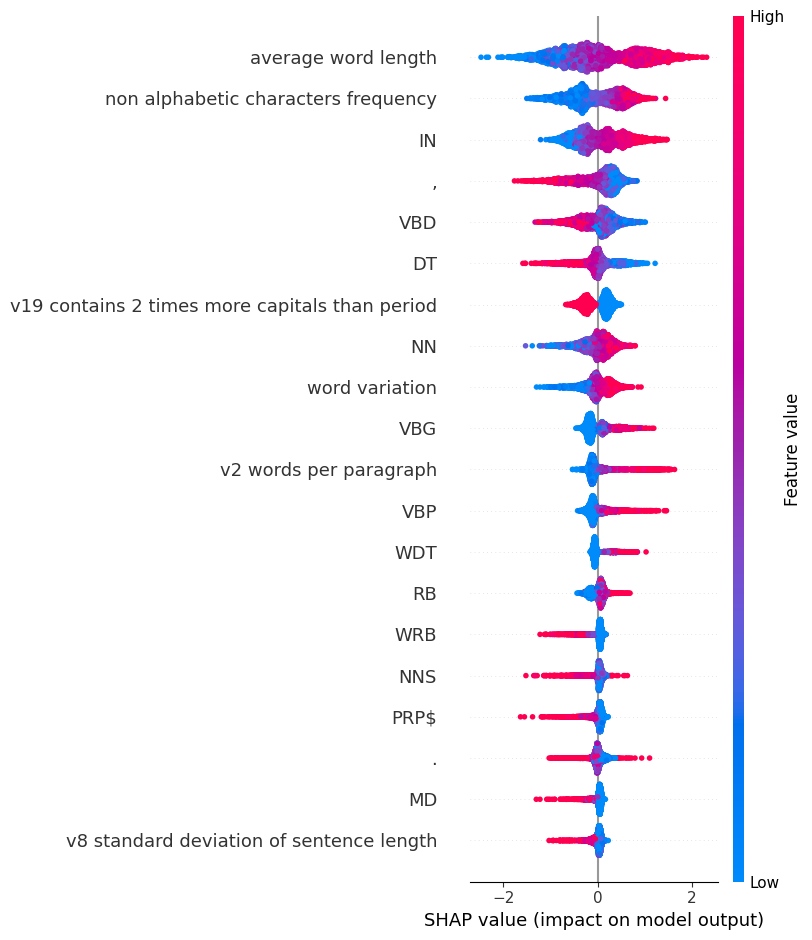

<Figure size 640x480 with 0 Axes>

In [43]:

shap.summary_plot(
    shap_vals,
    test_data,
    show=False,
)

plt.savefig(
    gutenberg_kfold_figure_dir_path.joinpath("shap_summary_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()


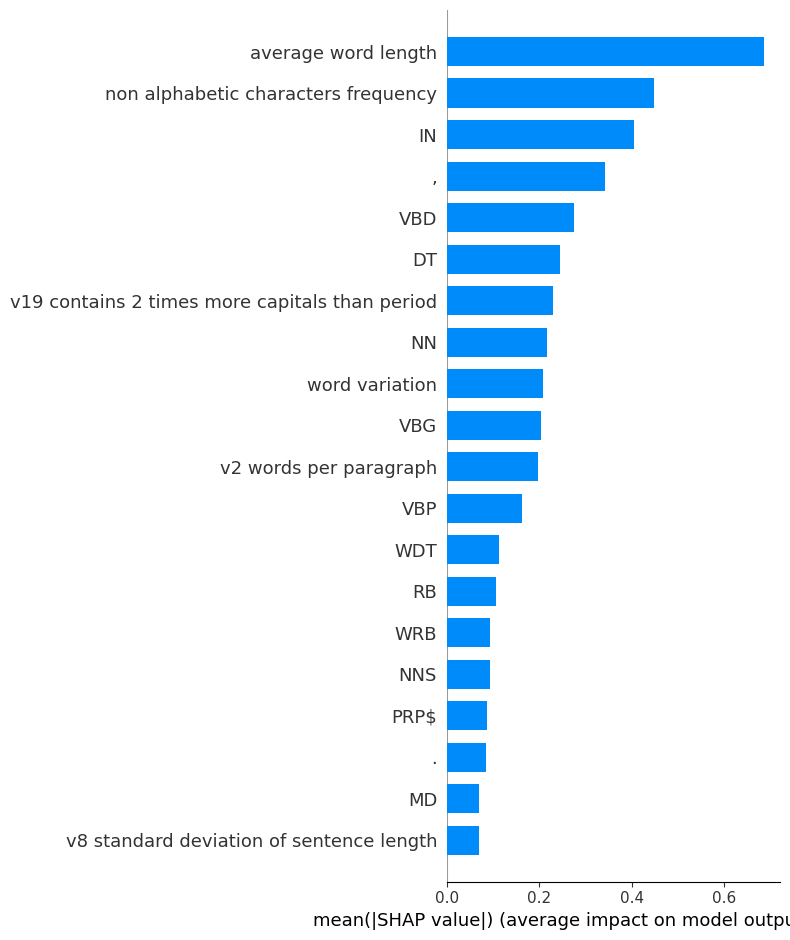

<Figure size 640x480 with 0 Axes>

In [44]:
shap.summary_plot(
    shap_vals,
    test_data,
    plot_type="bar",
    show=False,
)

plt.savefig(
    gutenberg_kfold_figure_dir_path.joinpath("shap_summary_plot_bar.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()
